# Youtube Title Analysis
### - Ann McHealy

### Introduction

This project uses the dataset ["Trending Youtube Video Statistics" from Kaggle](https://www.kaggle.com/datasnaek/youtube-new). Youtube does not curate the dataset but is responsible for determining what is 'trending' based on a proprietary algorithm. The dataset contains a snapshot of the top trending videos from each day, ranging from December 1, 2017 to May 31, 2018. 

The original goal of the project was to determine the most popular sentence structure of top trending Youtube videos. However, as you will see, the structure of video titles does not lend itself to a grammatical approach. Instead, this project focuses on the most common sequences of parts of speech in title segments and also reveals a few fun facts about the dataset.

### Data Import

This step loads in two raw files:
- a Youtube dataset specific to the United States
- a translation of NLTK shorthand codes into their corresponding parts of speech

In [1]:
import os
import re
import csv
import sys
import nltk
from nltk.corpus import stopwords
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# pd.set_option('display.max_colwidth', -1)

input_file = 'USvideos.csv'
pos_file = 'parts_of_speech.csv'

with open(input_file, 'r') as youtube_data:
    masterdata_csv = list(csv.reader(youtube_data))

pos_dict = {}
with open(pos_file, 'r') as parts_of_speech:
    pos_load = csv.reader(parts_of_speech)
    for row in pos_load:
        pos_dict[row[0]] = row[1]
        

def open_db(database):
    db = sqlite3.connect(database)
    db.execute('PRAGMA foreign_keys = ON;')
    return db

####  My First Decorator

In [2]:
def sql_decorator(func):
    
    def sql_action(statement, opt_args = None):
        db = None
        try:
            db = open_db('youtube.db')
            c = db.cursor()
            f = func(db, c, statement, opt_args)
            if f is not None or f:
                return f
            db.commit()
            
        except:
            print("There was an error: {}".format(sys.exc_info()[1]))

        finally:
            db.rollback()
            db.close()
            

    return sql_action

@sql_decorator
def run_sql(db, c, statement, opt_args):
    if opt_args == None:
        opt_args = []
    c.execute(statement, opt_args)

@sql_decorator
def run_sql_many(db, c, statement, opt_args):
    c.executemany(statement, opt_args)

@sql_decorator
def run_sql_fetchall(db, c, statement, opt_args):
    if opt_args == None:
        opt_args = []
    c.execute(statement, opt_args)
    return c.fetchall()

@sql_decorator
def run_sql_pd(db, c, statement, opt_args):
    return pd.read_sql_query(statement, db)


#### Define classes to facilitate analysis...and for practice

In [3]:
class Video:
    
    def __init__(self, video_id, title):
        self.video_id = video_id
        self.title = title
    
    def longest_word(self):
        longest_length = 0
        longest_word = None
        for word in self.title:
            if len(word) > longest_length:
                longest_length = len(word)
                longest_word = word
            else:
                continue
        return longest_word

    def title_segments(self):
        list = re.compile("(?:\||(?:\s-\s)|—|:|\(|\)|\[|\]|{|})+").split(self.title)
        # ?: indicates a non-capture group so delimiters aren't saved. Now I know.
        list = filter(lambda x: x != None, list)
        #  python is returning None where the delimiter was. Removing Nones.
        segments = []
        for text in list:
            text = text.strip()
            if text == "":
                continue
            segments.append(Segment(self.video_id, text))
        return segments

    
class Segment:
    
    def __init__(self, video_id, text):
        self.video_id = video_id
        self._text = text
        
    def text(self):
        lower_words = self._text.lower()
        return re.sub('[^A-Za-z0-9\s\-\']+', '', lower_words)
    
    def words(self):
        list = self.text().split()
        list = filter(lambda x: x != None, list)
        #  python is returning None where the delimiter was. Removing Nones.
        segments = []
        for item in list:
            text = item.strip()
            if text == "":
                continue
            segments.append(text)
        return segments
    
    def parts_of_speech(self):
        text = nltk.word_tokenize(self.text())
        tagged_text = nltk.pos_tag(text)
        #  creates list of tuples with (word, part of speech)
        return [item[1] for item in tagged_text]

class Title_glob:
    
    def __init__(self, glob):
        self.glob = glob
    
    def word_list(self):
        return self.glob
    
    def no_stop_words(self):
        stop_words = set(stopwords.words('english'))
        return [word for word in self.glob if not word in stop_words]
    
    def frequency_distribution(self):
        return nltk.FreqDist(self.glob)
    
    def lexical_diversity(self):
        return len(set(self.glob)) / len(self.glob)
    

### Loading and Tidying the Data

#### Create database and master table

In [4]:
try : 
    os.remove('youtube.db')
except FileNotFoundError:
    pass

In [5]:
create_statement_master = '''
    CREATE TABLE masterData (
    id INTEGER AUTOIMCREMENT PRIMARY KEY,
    video_id TEXT,
    trending_date TEXT,
    title TEXT,
    channel_title TEXT,
    category_id INTEGER,
    publish_time INTEGER,
    tags TEXT,
    views INTEGER,
    likes INTEGER,
    dislikes INTEGER,
    comment_count INTEGER,
    thumbnail_link TEXT,
    comments_disabled TEXT,
    ratings_disabled TEXT,
    video_error_or_removed TEXT,
    description TEXT)
    '''

run_sql(create_statement_master)

#### Save column headers into a dictionary and delete column header row

In [6]:
headers = masterdata_csv[0]
headers_dict = {}

for count, value in enumerate(headers, 1):
    headers_dict[value] = count -1
# to keep from 0 indexing my columns

del masterdata_csv[0]

#### Load data into master table

In [7]:
load_statement_master = '''
    INSERT INTO masterData
    (video_id,
    trending_date,
    title,
    channel_title,
    category_id,
    publish_time,
    tags,
    views,
    likes,
    dislikes,
    comment_count,
    thumbnail_link,
    comments_disabled,
    ratings_disabled,
    video_error_or_removed,
    description)
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    '''

source = masterdata_csv

run_sql_many(load_statement_master, source)

In [8]:
run_sql_pd('SELECT * FROM masterData LIMIT 2;')


,id,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,None,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,None,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."


#### After reviewing master data, create two tables based on function -- one static, one transactional

In [9]:
create_statement_video = '''
    CREATE TABLE videos (
    video_id TEXT PRIMARY KEY NOT NULL,
    title TEXT NOT NULL,
    channel_title TEXT NOT NULL,
    publish_time INTEGER NOT NULL,
    tags TEXT NOT NULL,
    thumbnail_link TEXT NOT NULL,
    comments_disabled TEXT NOT NULL,
    ratings_disabled TEXT NOT NULL,
    video_error_or_removed TEXT NOT NULL,
    description TEXT NOT NULL)
    '''

run_sql(create_statement_video)

create_statement_time = '''
    CREATE TABLE time (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    video_id TEXT NOT NULL,
    trending_date TEXT NOT NULL,
    views INTEGER NOT NULL,
    likes INTEGER NOT NULL,
    dislikes INTEGER NOT NULL,
    comment_count INTEGER NOT NULL,
        FOREIGN KEY(video_id) REFERENCES videos(video_id))
    '''

run_sql(create_statement_time)

#### Date is stored in hard-to-read format. Transform date column.

In [10]:
for row in masterdata_csv:
    date = row[headers_dict['trending_date']]
    updated_date = "20" + date[:2]
    updated_date += "-"
    updated_date += date[6:]
    updated_date += "-"
    updated_date += date[3:5]
    row[headers_dict['trending_date']] = updated_date

#### Titles contain characters + and &. These will not be parseable. Replacing with 'and'.

In [11]:
for row in masterdata_csv:
    title = row[headers_dict['title']]
    updated_title = re.sub('&|\+', 'and', title)
    row[headers_dict['title']] = updated_title

#### Separate CSV file into lists to be loaded to each table

In [12]:
video_data = []
time_data = []

for row in masterdata_csv:
    video_entry = [row[headers_dict['video_id']], 
                   row[headers_dict['title']], 
                   row[headers_dict['channel_title']], 
                   row[headers_dict['publish_time']],
                   row[headers_dict['tags']],
                   row[headers_dict['thumbnail_link']],
                   row[headers_dict['comments_disabled']],
                   row[headers_dict['ratings_disabled']],
                   row[headers_dict['video_error_or_removed']],
                   row[headers_dict['description']]
                  ]
    
    video_data.append(video_entry)
    
    time_entry = [row[headers_dict['video_id']], 
                  row[headers_dict['trending_date']], 
                  row[headers_dict['views']], 
                  row[headers_dict['likes']],
                  row[headers_dict['dislikes']],
                  row[headers_dict['comment_count']]
                 ]
    
    time_data.append(time_entry)

#### Load data to tables

In [13]:
load_statement_videos = '''
    INSERT OR REPLACE INTO videos
    (video_id,
    title,
    channel_title,
    publish_time,
    tags,
    thumbnail_link,
    comments_disabled,
    ratings_disabled,
    video_error_or_removed,
    description)
    VALUES (?,?,?,?,?,?,?,?,?,?)
    '''

run_sql_many(load_statement_videos, video_data)


In [14]:
load_statement_time = '''
    INSERT INTO time
    (video_id,
    trending_date,
    views,
    likes,
    dislikes,
    comment_count)
    VALUES (?,?,?,?,?,?)
    '''

run_sql_many(load_statement_time, time_data)

#### Test for foreign key failure

In [15]:
failure_statement = "INSERT INTO time VALUES (?, ?, ?, ?, ?, ?, ?)"
failure_args = (None, "testy", "18.11.11", 1, 1, 1, 1)

run_sql(failure_statement, failure_args)

There was an error: FOREIGN KEY constraint failed


#### Sample of final Videos table

In [16]:
run_sql_pd('SELECT * FROM videos LIMIT 2;')

,video_id,title,channel_title,publish_time,tags,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,9wRQljFNDW8,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13T02:05:26.000Z,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...
1,Om_zGhJLZ5U,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12T18:00:03.000Z,"screenjunkies|""screen junkies""|""sj news""|""hone...",https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...


#### Sample of final Times table

In [17]:
run_sql_pd('SELECT * FROM time LIMIT 2;')

,id,video_id,trending_date,views,likes,dislikes,comment_count
0,1,2kyS6SvSYSE,2017-11-14,748374,57527,2966,15954
1,2,1ZAPwfrtAFY,2017-11-14,2418783,97185,6146,12703


### Segments
In looking at the titles (see random sample below), each title is not necessarily a full sentence. The titles are, instead, composed of sequences of title segments. The title segments are also often not complete sentences. At this point, an analysis of the sentence structure doesn't make sense for the data. Fresh tactics!

In [18]:
pd.set_option('display.max_colwidth', -1)
run_sql_pd('SELECT title FROM videos ORDER BY title ASC LIMIT 10;')

,title
0,#184 Making a PCB using EasyEDA. // Review
1,"#23 Feed The Homeless | One List, One Life"
2,#57: AM and SSB explained
3,"#AboveTheNoise feat. Serena Williams, Neymar Jr., Cara Delevingne, Michael K. Williams, and Kris Wu"
4,#DisneyParksLIVE: Fantasy In The Sky New Years Eve Fireworks | Disney World
5,#DisneyParksLIVE: Super Bowl Celebration | Walt Disney World
6,#EDGYTOKEI
7,#GuacWorld :60 | 2018 Big Game Commercial | Avocados From Mexico
8,#HurtBae 2: One Year Later - Kourtney and Leonard Meet Again | Iris
9,#LightTheWorld Christmas Concert with The Piano Guys and Friends


####  Create Segments table to store segments of each title for analysis. 

In [19]:
create_statement_segments = '''
    CREATE TABLE segments (
    segment_id INTEGER PRIMARY KEY AUTOINCREMENT,
    video_id TEXT NOT NULL,
    segment_text TEXT NOT NULL,
    segment_structure TEXT,
        FOREIGN KEY(video_id) REFERENCES videos(video_id))
    '''

run_sql(create_statement_segments)

#### Select data from Videos table to parse into segments, generate parts of speech for each, and commit to Segments table

- Segments are split on special characters: "|", "-", ":", ";", "/", "\", ")", "(", "[", "]", "{", "}"
- Segments are not split when a hyphen forms an adjective (e.g. well-groomed cat) by checking for spaces on either side of the hyphen.
- Parts of speech are generated by using the pos_tag function in the NLTK.
- Both process are methods of the Segment class.

In [20]:
titles_list = run_sql_fetchall("SELECT video_id, title FROM videos;")

In [21]:
segment_entries=[]

for row in titles_list:
    video = Video(row[0], row[1])
    segments = video.title_segments()
    for segment in segments:
        segment_entry = []
        segment_entry.append(segment.video_id)
        segment_entry.append(segment.text())
        segment_entry.append(", ".join(segment.parts_of_speech()))
        segment_entries.append(segment_entry)

In [22]:
insert_statement_segments = '''
        INSERT INTO segments
        (video_id,
        segment_text,
        segment_structure)
        VALUES (?,?, ?)
        '''
source = segment_entries

run_sql_many(insert_statement_segments, source)


In [23]:
run_sql_pd('SELECT * FROM segments WHERE segment_id>=(abs(random()) % (SELECT max(segment_id)FROM segments)) LIMIT 5')

,segment_id,video_id,segment_text,segment_structure
0,8933,KyQyz2upSgY,casually explained,"RB, VBD"
1,8934,KyQyz2upSgY,men's fashion,"NNS, POS, NN"
2,8935,wAQ7autd61g,the final countdown,"DT, JJ, NN"
3,8936,wAQ7autd61g,europe,NN
4,8937,wAQ7autd61g,vintage cabaret cover,"NN, NN, NN"


In [24]:
segments_list = run_sql_fetchall("SELECT video_id, segment_text, segment_id FROM segments;")

#### Concatenate all segments for analysis as a whole using the Title_glob class

In [25]:
def lower_case(list):
    return [w.lower() for w in list]

all_segment_words = []

for item in segments_list:
    segment = Segment(item[0], item[1])
    segment_words = segment.words()
    for word in segment_words: 
        all_segment_words.append(word)

all_segment_words = lower_case(all_segment_words)

all_words = Title_glob(sorted(all_segment_words))
# print(all_words.word_list())

all_tokens = Title_glob(sorted(set(all_segment_words)))
# print(all_tokens.word_list())

#### The X most common words - unfiltered. 
Update number_most_common below if you'd like to see other lists

In [26]:
number_most_common = 10

def transform_for_pandas_freq(list):
    final_list = []
    for item in list:
        entry = {}
        entry['word'] = item[0]
        entry['frequency'] = item[1]
        final_list.append(entry)
    return final_list

freq_dist = all_words.frequency_distribution()

most_common_list_all = freq_dist.most_common(number_most_common)

most_common_all = transform_for_pandas_freq(most_common_list_all)

pd.DataFrame(most_common_all)


,frequency,word
0,1627,the
1,753,and
2,748,a
3,685,to
4,538,in
5,531,of
6,486,official
7,470,with
8,405,on
9,361,2018


#### The X most common words - filtered to exclude stop words:
A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 

In [27]:
no_stops = all_words.no_stop_words()

no_stop_words = Title_glob(no_stops)

freq_dist = no_stop_words.frequency_distribution()

most_common_list_no_stop = freq_dist.most_common(number_most_common)

most_common_no_stop = transform_for_pandas_freq(most_common_list_no_stop)

df_no_stop = pd.DataFrame(most_common_no_stop)
df_no_stop

,frequency,word
0,486,official
1,361,2018
2,317,video
3,276,trailer
4,178,vs
5,175,2017
6,170,new
7,155,ft
8,144,live
9,141,first


In [28]:
labels_list_words = []

for item in most_common_list_no_stop:
    labels_list_words.append(item[0])

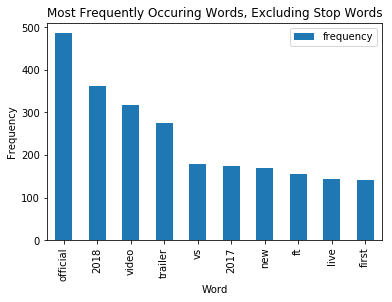

In [29]:
data = df_no_stop
fig, ax = plt.subplots()
plt.title('Most Frequently Occuring Words, Excluding Stop Words')
plt.ylabel('Frequency')
plt.xlabel('Word')
data.plot(ax=ax, kind='bar')
ax.set_xticklabels(labels_list_words)
plt.show()

#### The X most common words - filtered - by total views:
Each video may  be logged several times (no more than once per day) if the video continues to trend. This function selects the number of views on the max trending date to get the final total of views on record. 

Views for each video with a title containing one of the top ten content words are aggregated.

In [30]:
def get_hits(word):
    fetch_statement_video = "SELECT video_id FROM videos WHERE title LIKE '%{}%'".format(word)
    videos = run_sql_fetchall(fetch_statement_video)
    
    video_id_list = []
    
    for item in videos:
        video_id_list.append(item[0])
        
    total_views = 0
    
    for id in video_id_list:
        fetch_statement_max_date = """
            SELECT video_id, max(trending_date)
            FROM time
            GROUP BY video_id
            HAVING video_id = '{}'""".format(id)
        date = run_sql_fetchall(fetch_statement_max_date)
        
        video_id = date[0][0]
        max_date = date[0][1]

        fetch_statement_views = "SELECT views FROM time WHERE video_id = '{}' AND trending_date = '{}'".format(video_id, max_date)
        views = run_sql_fetchall(fetch_statement_views)
        total_views += views[0][0]

    return total_views

In [31]:
hits_dict_list = []

for word in labels_list_words:
    hits_dict_entry = {}
    hits_dict_entry['word'] = word
    hits_dict_entry['views'] = get_hits(word)
    hits_dict_list.append(hits_dict_entry)

df_top_10_views = pd.DataFrame(hits_dict_list)

df_top_10_sorted = df_top_10_views.sort_values('views', 0, False)

df_top_10_sorted

,views,word
0,3689644625,official
2,2483253180,video
3,1265342216,trailer
7,1225476113,ft
1,691212494,2018
5,318554491,2017
4,316564504,vs
8,235075468,live
6,191770814,new
9,131103622,first


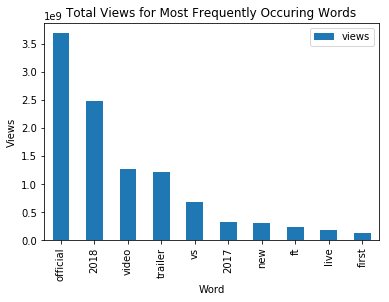

In [32]:
data = df_top_10_sorted
fig, ax = plt.subplots()
plt.title('Total Views for Most Frequently Occuring Words')
plt.ylabel('Views')
plt.xlabel('Word')
data.plot(ax=ax, kind='bar')
ax.set_xticklabels(labels_list_words)
plt.show()

#### Views by frequency for top 10 most commonly occurring words

In [33]:
top_10_summary = []
for item in most_common_no_stop:
    entry = {}
    word = item['word']
    entry['word'] = word
    entry['frequency'] = item['frequency']
    for item in hits_dict_list:
        if item['word'] == word:
            views = item['views']
    entry['views'] = views
    entry['average_views_by_video'] = round(entry['views']/entry['frequency'], 0)
    
    top_10_summary.append(entry)

df_top_10_summary = pd.DataFrame(top_10_summary).sort_values('average_views_by_video', 0, False)

df_top_10_summary

,average_views_by_video,frequency,views,word
7,7906298.0,155,1225476113,ft
2,7833606.0,317,2483253180,video
0,7591861.0,486,3689644625,official
3,4584573.0,276,1265342216,trailer
1,1914716.0,361,691212494,2018
5,1820311.0,175,318554491,2017
4,1778452.0,178,316564504,vs
8,1632469.0,144,235075468,live
6,1128064.0,170,191770814,new
9,929813.0,141,131103622,first


#### Lexical diversity
This is generated by dividing the length of the set of unique words over the length of  the set of all words.

In [34]:
print("The lexical diversity of the corpus is {}.".format(all_words.lexical_diversity()))
print("There are {} words in the corpus.".format(len(all_words.word_list())))
print("There are {} unique words.".format(len(all_tokens.word_list())))


The lexical diversity of the corpus is 0.21445316284025961.
There are 51615 words in the corpus.
There are 11069 unique words.


#### [For context](https://pudding.cool/2017/02/vocabulary/index.html)
- Wu Tang Clan uses 5,895 unique words in a set of their first 35,000 lyric tokens for a lexical diversity of 0.1684
- Shakespeare uses 5,170 unique words in a set of 35,000 word tokens (the first 5,000 from 7 different works) for a lexical diversity of 0.1477

#### Longest word

In [35]:
longest_word = ''
longest_length = 0

for word in all_tokens.word_list():
    if len(word) > longest_length:
        longest_word = word
        longest_length = len(word)

print("The longest word in the corpus is {} with a length of {} characters".format(longest_word, longest_length))

The longest word in the corpus is brfxxccxxmnpcccclllmmnprxvclmnckssqlbb11116 with a length of 43 characters


You should totally check this word out on Youtube. NOT what I was expecting.

#### Greatest number of segments per title

In [36]:
segments_statement = """
            SELECT count(segment_id) as number_of_segments, video_id 
            FROM segments 
            GROUP BY video_id 
            ORDER BY number_of_segments desc
            LIMIT 6;
            """

segments_count = run_sql_pd(segments_statement)

segments_count

,number_of_segments,video_id
0,6,07JQ4WZJIbg
1,6,IxF3mxWbdjw
2,6,JWH5KE1atAg
3,6,XiHiW4N7-bo
4,6,Yq4_YocuVeg
5,6,Zjp0mdMeIPU


The most segments contained in any given title is 6.

In [37]:
sample_6_statement = 'SELECT * from segments WHERE video_id = "07JQ4WZJIbg"'
sample_6 = run_sql_pd(sample_6_statement)

full_title_6_statement = 'SELECT title from videos WHERE video_id = "07JQ4WZJIbg"'
pd.set_option('display.max_colwidth', -1)
run_sql_pd(full_title_6_statement)

,title
0,Marvel's VENOM (2018) - Full Trailer | Tom Hardy Movie (HD) Concept


In [38]:
pd.set_option('display.max_colwidth', 0)
sample_6

,segment_id,video_id,segment_text,segment_structure
0,7660,07JQ4WZJIbg,marvel's venom,"NN, POS, NN"
1,7661,07JQ4WZJIbg,2018,CD
2,7662,07JQ4WZJIbg,full trailer,"JJ, NN"
3,7663,07JQ4WZJIbg,tom hardy movie,"NN, JJ, NN"
4,7664,07JQ4WZJIbg,hd,NN
5,7665,07JQ4WZJIbg,concept,NN


...It thinks 'hardy' of Tom Hardy is an adjective. What can ya do?

#### Average number of segments per title

In [39]:
count_segments_statement = """
            SELECT count(segment_id) as number_of_segments, video_id 
            FROM segments 
            GROUP BY video_id;
            """
df = run_sql_pd(count_segments_statement)
df.mean()

number_of_segments    1.855141
dtype: float64

The mean number of segments per title is 1.855141

#### Diversity of part-of-speech sequences in title segments

In [40]:
repeated = """
        SELECT count(video_id) as number_of_pattern_occurances
        FROM segments 
        GROUP BY segment_structure
        HAVING number_of_pattern_occurances > 1
        ORDER BY number_of_pattern_occurances DESC;
        """

every = """
    SELECT count(video_id) as number_of_pattern_occurances
    FROM segments 
    GROUP BY segment_structure
    ORDER BY number_of_pattern_occurances DESC;
    """

df_repeated = run_sql_pd(repeated)
df_all = run_sql_pd(every)

print( """
        The number of repeated grammatical patterns is {}.
        There are a total of {} unique grammatical patterns found in title segments."""
        .format(len(df_repeated.index), len(df_all.index)))



        The number of repeated grammatical patterns is 654.
        There are a total of 5173 unique grammatical patterns found in title segments.


#### The top 10 part-of-speech sequences

In [41]:
select_statement_top_10 = '''
    SELECT count(video_id) as number_of_pattern_occurances, segment_structure
    FROM segments
    GROUP BY segment_structure
    ORDER BY number_of_pattern_occurances DESC
    LIMIT 10;'''

top_10 = run_sql_fetchall(select_statement_top_10)

In [42]:
def translate_structure(item):
    item_list = item[1].split(", ")
    expanded_structure = []
    for pos in item_list:
        expanded_structure.append(pos_dict[pos])
    return expanded_structure

def build_list(my_list):
    new_list = []
    for item in my_list:
        entry = {}
        entry['frequency'] = item[0]
        entry['segment_structure'] = item[1]
        entry['structure_explanation'] = translate_structure(item)
        new_list.append(entry)
    return new_list

df_top_10 = pd.DataFrame(build_list(top_10))

df_top_10

,frequency,segment_structure,structure_explanation
0,1349,NN,"[noun, singular: 'desk']"
1,817,"NN, NN","[noun, singular: 'desk', noun, singular: 'desk']"
2,608,"JJ, NN","[adjective, base: 'big', noun, singular: 'desk']"
3,216,"NN, NNS","[noun, singular: 'desk', noun plural:'desks']"
4,197,"JJ, NN, NN","[adjective, base: 'big', noun, singular: 'desk', noun, singular: 'desk']"
5,182,"NN, NN, NN","[noun, singular: 'desk', noun, singular: 'desk', noun, singular: 'desk']"
6,133,"NN, CD","[noun, singular: 'desk', cardinal digit]"
7,116,"DT, NN","[determiner, noun, singular: 'desk']"
8,114,NNS,[noun plural:'desks']
9,104,CD,[cardinal digit]


In [43]:
labels_list = []

for item in top_10:
    labels_list.append(item[1])

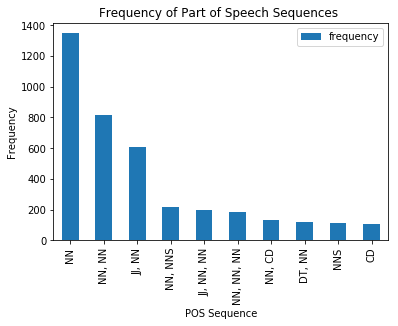

In [44]:
data = df_top_10
fig, ax = plt.subplots()
plt.title('Frequency of Part of Speech Sequences ')
plt.ylabel('Frequency')
plt.xlabel('POS Sequence')
data.plot(ax=ax, kind='bar')
ax.set_xticklabels(labels_list)
plt.show()

### Conclusion

Though I did not find what I had come to find, several interesting features of the data set are apparent. The main finding is that Youtube video titles do not come in complete sentences, but rather small units of meaning. While the average number of segments per title in this data set is just under two, some titles had as many as six segments.

Among segments, the single noun is king! This is followed by two consecutive nouns and an adjective/noun combination. All other part-of-speech sequences are much less represented with only 654 of the total 5173 sequences repeated at least once.

The lexical content of the titles is incredibly varied (More than Wu Tang! More than Shakespeare!). Of the most common words that are not stop words, 'official' is by far the most highly represented, followed by '2018', 'video', and 'trailer'. The word 'official' is the most frequently occurring in individual titles. Videos with the word 'official' in their titles also have the most views. However, videos with the word 'ft' in their titles receive more view per occurrence than videos with any other of the 10 most common words. I would guess that this is related to 'ft' being used in music video titles which would be must more frequently watched than other video types.